In [ ]:
!pip install torch==1.12.1

In [1]:
!pip install fastai

     -------------------------------------- 232.8/232.8 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 67.6/67.6 kB 3.8 MB/s eta 0:00:00
  Using cached matplotlib-3.5.3-cp37-cp37m-win_amd64.whl (7.2 MB)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rich 12.6.0 requires typing-extensions<5.0,>=4.0.0; python_version < "3.9", but you have typing-extensions 3.10.0.2 which is incompatible.
parlai 1.5.1 requires importlib-metadata<4.3, but you have importlib-metadata 4.11.3 which is incompatible.
parlai 1.5.1 requires myst-parser~=0.12.2, but you have myst-parser 0.18.1 which is incompatible.
parlai 1.5.1 requires Sphinx~=2.2.0, but you have sphinx 5.3.0 which is incompatible.
parlai 1.5.1 requires tqdm~=4.62.1, but you have tqdm 4.64.1 which is incompatible.
flake8 4.0.1 requires importlib-metadata<4.3; python_version < "3.8", but you have importlib-metadata 4.11.3 which is incompatible.
aiohttp 3.7.4.post0 requires async-timeout<4.0,>=3.0, but you have async-timeout 4.0.2 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] 


  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0


In [29]:
import os
import sys
import numpy as np
import pandas as pd

from timm import create_model
import fastai
from fastai.vision.all import *
import timm
set_seed(999, reproducible=True)

In [12]:
dataset_path_train = './'

dataset_path_test = './'

In [56]:
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models), avail_pretrained_models[:5]


(452,
 ['adv_inception_v3',
  'cait_m36_384',
  'cait_m48_448',
  'cait_s24_224',
  'cait_s24_384'])

In [57]:
# model names in timm, corresponding image input sizes and weights in the final model blend

# TIMM_MODELS = (('vit_large_patch14_clip_224.openai_ft_in1k', 384, 1.0), ('swin_large_patch4_window12_384', 384, 0.168), ('vit_large_patch14_clip_336', 336, 0.063), 
            #    ('beit_large_patch16_384', 384, 0.261), ('beitv2_large_patch16_224', 224, 0.087), ('beit_large_patch16_224.in22k_ft_in22k', 224, 0.232))
TIMM_MODELS = ('vit_tiny_patch16_224', 224, 1.0)

In [58]:
train_df = pd.read_csv(dataset_path_train + 'train.csv')
train_df['path'] = train_df['image'].map(lambda x: str(dataset_path_train + 'images/images/' + x))
train_df = train_df.drop(columns=['image'])
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [59]:
file_list = pd.read_csv(dataset_path_train + 'test.csv')

test_df = pd.DataFrame(file_list, columns=['image'])
test_df['path'] = test_df['image'].map(lambda x:str(dataset_path_test+'images/images/'+x))
test_df = test_df.drop(columns=['image'])

test_df['class_id'] = [0]*len(test_df)


In [60]:
test_df.shape

(31718, 2)

In [61]:
def train_and_predict(model):

    model_name = model[0]
    img_size = model[1]

    dls = ImageDataLoaders.from_df(train_df,
                               valid_pct=0.0,
                               seed=999,
                               fn_col='path',
                               label_col='class_id',
                               y_block=CategoryBlock,
                               bs=8,
                               num_workers=2,
                               item_tfms=Resize(img_size),
                               batch_tfms=aug_transforms(size=img_size))

    model = create_model(model_name, pretrained=True, num_classes=dls.c)

    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

    learn.fit_one_cycle(3, 2e-5)

    test_dl = dls.test_dl(test_df)

    prediction, _ = learn.tta(dl=test_dl, n=7)

    return prediction

In [62]:
prediction_blend = []

# for model in TIMM_MODELS:
model = TIMM_MODELS
prediction = train_and_predict(model)

model_weight = model[2]

prediction_blend.append(model_weight*prediction)

UnidentifiedImageError: cannot identify image file '.\\./images/images/gTzMpvSEl9Q6ysXUw5J34LWfhqZYij0BCmaHIxkN.jpg'

In [ ]:
prediction_final = sum(prediction_blend)

test_df['class_id'] = np.argmax(prediction_final, axis=1)

test_df[['image_name', 'class_id']].to_csv('submission.csv', index=False, sep='\t')

1677557442.0 03b8LYVsuXgeyoShqITkMWF4PjvUKJOrwldnfQtA.jpg


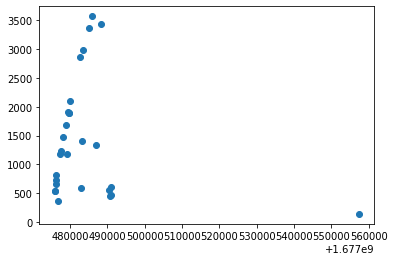

In [35]:
import os
import platform
import pandas as pd
def creation_date(path_to_file):
    """
    Try to get the date that a file was created, falling back to when it was
    last modified if that isn't possible.
    See http://stackoverflow.com/a/39501288/1709587 for explanation.
    """
    if platform.system() == 'Windows':
        return os.path.getctime(path_to_file)
    else:
        stat = os.stat(path_to_file)
        try:
            return stat.st_birthtime
        except AttributeError:
            # We're probably on Linux. No easy way to get creation dates here,
            # so we'll settle for when its content was last modified.
            return stat.st_mtime

def get_class_id(path, df): 
    return df[df['image']==path]['class_id']

df_classes = pd.read_csv("train.csv")
import glob
import matplotlib.pyplot as plt
i = 0
x = []
y = []
for file in glob.glob("./images/images/*.jpg"):
    image = file.split("\\")[-1]
    class_number = get_class_id(image, df_classes)
    if len(class_number) > 0:
        class_number = class_number.values[0]
    else:
        continue
    cr_date = creation_date("./images/images/" + image) # 0
    x.append(cr_date)
    y.append(class_number)
    if cr_date > 1677548262.0:
        print(cr_date,image)
        break
    # print(cr_date, class_number)
    i+=1
plt.scatter(x, y)

# print(creation_date("./images/images/vediWE6cXt1ayjU7gNYp4TxKR5F09QsDSqr8GmhL.jpg")) # 0 
# print(creation_date("./images/images/MTI84YVHwc1KUWdu7LqzEFZmkGJb9ofQxvCAeO5D.jpg")) # 100
# print(creation_date("./images/images/IQvZWKslpkqPgFOacdw6y9VT3S1moMu45zL7eChH.jpg")) # 500
# print(creation_date("./images/images/RU4SPDwouXM8QJbLd7AfIvH2VWleN3hpq0YEtjzO.jpg")) # 500
# print(creation_date("./images/images/sqym3bgzLoDWnHI67EJURTG2iulXptfakS4cKVBh.jpg")) # 500


In [20]:
ab.values[0]

1000